# Report for mini-project 1

Student: Lucas Gerretsen

Instructor: M. Lepetit

Deadline: 21/12/2018

In [3]:
# ///!\\\ for some reason, this cell throws an error at first run, and should therefore be run twice
import mp1
from importlib import reload
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import numpy as np
import keras
from keras import backend as K
from tqdm import tqdm_notebook as tqdm

print(mp1.IMAGE_SIZE)

72


<module 'mp1' from '/home/lucas/Documents/MVA/DL/MP1/mp1.py'>

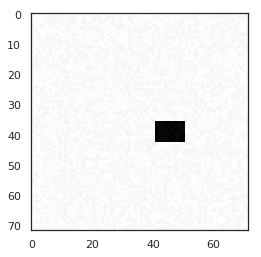

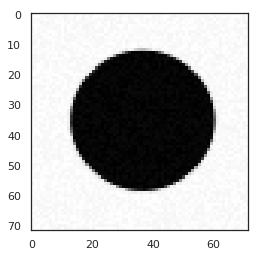

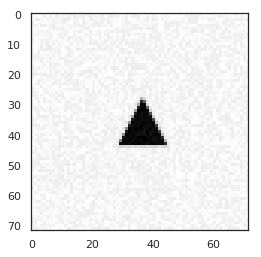

In [14]:
sns.set(style='white')
reload(mp1)

## Q3

Our goal here is to train and evaluate a simple linear network on recognizing shapes: rectangle/disk/triangle.

In [24]:
# generate a train set
[X_train_3, Y_train_3] = mp1.generate_dataset_classification(300, 20)
Y_train_3 = np.eye(3)[Y_train_3.astype(int)] # equivalent to keras.utils.np_utils.to_categorical()
print(X_train_3.shape,Y_train_3.shape)

Creating data:



Categories: rectangle/disk/triangle
(300, 5184) (300, 3)


In [25]:
# generate a test set
[X_test_3, Y_test_3] = mp1.generate_dataset_classification(60, 20)
Y_test_3 = np.eye(3)[Y_test_3.astype(int)] # equivalent to keras.utils.np_utils.to_categorical()

Creating data:



Categories: rectangle/disk/triangle


In [37]:
# build a 1-layer, dense model
# we perform softmax on the output for this categorization problem and use appropriate loss and metric
model_3 = keras.models.Sequential()
model_3.add(keras.layers.Dense(3,activation=keras.activations.softmax)) # 3 outputs for the 3 categories
def reset_weights(model):
    """
    This function is used to compile model, but also to re-run initializers on weights
    """
    model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])
reset_weights(model_3)

In [39]:
# one single experiment
model_3.fit(x=X_train_3,y=Y_train_3,epochs=15,batch_size=32,verbose=0)
print(model_3.evaluate(X_test_3,Y_test_3))

60/60 [==============================] - 0s 480us/step
[0.06889191394050916, 1.0]


In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


In [41]:
### several reproduced experiments, and warying the number of epochs

# parameters for our experiment
n_exp = 3
n_epochs_s = [1,2,3,5,7,10,15]

# record stats - 0 = train/test - 1 = n_epochs - 2 = it_exp
record_loss = np.zeros((2,len(n_epochs_s),n_exp))
record_acc = np.zeros((2,len(n_epochs_s),n_exp))

for it_epochs,epochs in enumerate(tqdm(n_epochs_s)): # test different number of epochs
    for it in range(n_exp): # reproduce the experiment a few times
        # reset the model
        reset_weights(model_3)
        # train the model
        model_3.fit(x=X_train_3,y=Y_train_3,epochs=epochs,batch_size=32,verbose=0)
        # evaluate the model on train set
        loss,acc = model_3.evaluate(X_train_3,Y_train_3,verbose=0)
        record_loss[0,it_epochs,it] = loss
        record_acc[0,it_epochs,it] = acc
        # evaluate the model on test set
        loss,acc = model_3.evaluate(X_test_3,Y_test_3,verbose=0)
        record_loss[1,it_epochs,it] = loss
        record_acc[1,it_epochs,it] = acc

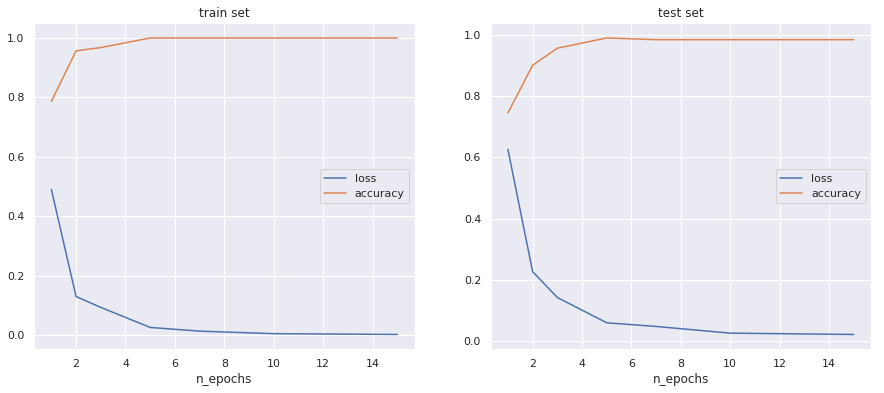

In [42]:
# plot stats gathered in above cell

sns.set(style='darkgrid')

plt.figure(figsize=(15,6))

plt.subplot(1,2,1) # plot stats for train set
plt.plot(n_epochs_s,record_loss[0,:,:].mean(axis=1),label='loss')
plt.plot(n_epochs_s,record_acc[0,:,:].mean(axis=1),label='accuracy')
plt.xlabel('n_epochs')
plt.title('train set')
plt.legend()

plt.subplot(1,2,2) # plot stats for test set
plt.plot(n_epochs_s,record_loss[1,:,:].mean(axis=1),label='loss')
plt.plot(n_epochs_s,record_acc[1,:,:].mean(axis=1),label='accuracy')
plt.xlabel('n_epochs')
plt.legend()
plt.title('test set')
plt.show()

As shown in above figures, this simple model is able to learn and discriminate the 3 different shapes (almost perfectly for `n_epochs=10`).

## Q4

We try and vizualize the aspect of the learned kernel associated to each category.

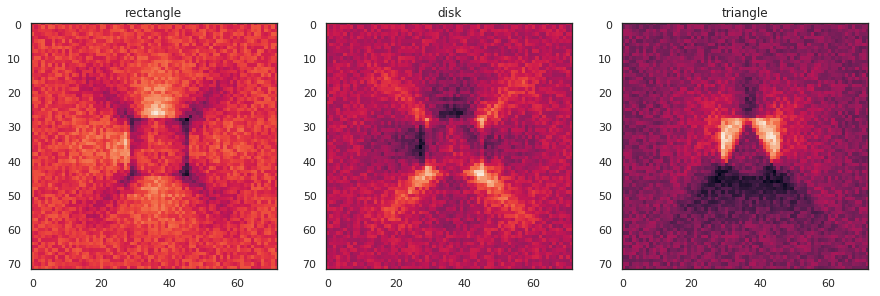

In [47]:
sns.set(style='white')

kernel_weights = np.array(model.get_weights()[0])
IMSIZE = int(mp1.IMAGE_SIZE)

plt.figure(figsize=(15,6))
for category in range(3):
    plt.subplot(1,3,category+1)
    plt.title(mp1.CATEGORIES[category])
    plt.imshow(kernel_weights[:,category].reshape((IMSIZE,IMSIZE)))
plt.show()

Looking at the above figures:
- fig1: we can vizualize in dark tones ditributions of the corners of observed rectangles whose location are specific to that shape as compared to the others
- fig3: we can vizualize in dark tones the same distribution for the triangle
- fig2: this figure, associated to the circle, shows corner locations of both rectangle and triangle in light tones, which suggests that the circle is recognized by elimination 

Note that the kernels are also quite random in the areas that are not discriminative.

## Q5

We try to solve a similar problem, but this time the shapes are not constrained to be generated in the center of the images. This problem is harder since our model will need better generalization capabilities. We use convolutional layers, which should help our model to be translation-invariant.

In [33]:
# generate a train set
[X_train_5, Y_train_5] = mp1.generate_dataset_classification(3000, 20,True)
Y_train_5 = np.eye(3)[Y_train_5.astype(int)] # equivalent to keras.utils.np_utils.to_categorical()
# generate a test set
[X_test_5, Y_test_5] = mp1.generate_test_set_classification()

Creating data:



Categories: rectangle/disk/triangle
Creating data:



Categories: rectangle/disk/triangle


In [15]:
### build a model
IMSIZE = int(mp1.IMAGE_SIZE)

model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Reshape((IMSIZE,IMSIZE,1),input_shape=X_train_5.shape[1:]))
model_cnn.add(keras.layers.Conv2D(16,(5,5),activation=keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D())
model_cnn.add(keras.layers.Conv2D(16,(5,5),activation=keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D())
model_cnn.add(keras.layers.Conv2D(16,(5,5),activation=keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D())
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(3,activation=keras.activations.softmax))

In [18]:
# train the model
model_cnn.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
             loss=keras.losses.categorical_crossentropy,
             metrics=[keras.metrics.categorical_accuracy])
model_cnn.fit(X_train_5,Y_train_5,epochs=20,verbose=1)
model_cnn.evaluate(X_test_5,Y_test_5)

Epoch 1/20
3000/3000 [==============================] - 28s 9ms/step - loss: 1.0932 - categorical_accuracy: 0.3800
Epoch 2/20
3000/3000 [==============================] - 26s 9ms/step - loss: 1.0720 - categorical_accuracy: 0.4727
Epoch 3/20
3000/3000 [==============================] - 28s 9ms/step - loss: 1.0286 - categorical_accuracy: 0.5100
Epoch 4/20
3000/3000 [==============================] - 27s 9ms/step - loss: 0.9614 - categorical_accuracy: 0.5443
Epoch 5/20
3000/3000 [==============================] - 29s 10ms/step - loss: 0.8976 - categorical_accuracy: 0.5803
Epoch 6/20
3000/3000 [==============================] - 32s 11ms/step - loss: 0.8485 - categorical_accuracy: 0.6027
Epoch 7/20
3000/3000 [==============================] - 27s 9ms/step - loss: 0.8053 - categorical_accuracy: 0.6310
Epoch 8/20
3000/3000 [==============================] - 27s 9ms/step - loss: 0.7701 - categorical_accuracy: 0.6460
Epoch 9/20
3000/3000 [==============================] - 26s 9ms/step - loss: 0

[0.38651240905125933, 0.8466666674613953]

In [17]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 16)        6416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 16)        6416      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
__________

Above model is a simple sequence of 3 convolution + max pooling followed by a dense layer. It achieves about 85% accuracy on the test set of the categorization problem.

Note that this model `model_cnn` has slightly less trainable parameters than `model_3` from Q3 (14.451 vs 15.555).

In [42]:
print(model_3.evaluate(X_test_3,Y_test_3))
print(model_3.evaluate(X_test_5,Y_test_5))
print(model_cnn.evaluate(X_test_3,Y_test_3))
print(model_cnn.evaluate(X_test_5,Y_test_5))

60/60 [==============================] - 0s 302us/step
[0.06889191394050916, 1.0]
300/300 [==============================] - 0s 190us/step
[3.0228178024291994, 0.3799999992052714]
60/60 [==============================] - 0s 5ms/step
[0.7831725796063741, 0.7666666785875956]
300/300 [==============================] - 1s 4ms/step
[0.38651240905125933, 0.8466666674613953]


... yet it shows good performances on both the simple and the harder dataset, which proves that it has better generalization potential (thanks once again to the convolutional layers).

## Q6

Here we work on a even harder problem, that is a regression problem. The goal is to find the coordinates of the 3 vertices of triangles of random shapes.

Considering the way that the datasets are generated, a NN cannot actually learn on it since the target vertices are aranged in a random order. We therefore need to process the dataset to have deterministic targets for a given triangle: we therefore reorder the vertices in ascending order according to their x coordinate (ie from left to right).

In [34]:
# generate a dataset
[X_train_6, Y_train_6] = mp1.generate_dataset_regression(3000, 20)
Y_mean_6 = Y_train_6.mean(axis=0)
Y_std_6 = Y_train_6.std(axis=0)
Y_train_6 = (Y_train_6 - Y_mean_6)/Y_std_6
[X_test_6, Y_test_6] = mp1.generate_test_set_regression()
Y_test_6 = (Y_test_6 - Y_mean_6)/Y_std_6
print(Y_mean_6,Y_std_6)

Creating data:



Creating data:



[0.5007172  0.4893968  0.50620971 0.50405767 0.50709938 0.49126323] [0.28878411 0.28555066 0.28645373 0.28469684 0.28766073 0.28638274]


In [35]:
# we reorder the vertices so that a triangle has 1 unique associated representation (instead of 6)

def reorder_vertices(coords):
    """
    Input: coords (?,6) = (x_1,y_1,x_2,y_2,x_3,y_3)
    Output: new_coords (?,6) such as each new_coords[i,:] is a specific permutation of coords[i,:],
            such as the same triangle is represented, but x are ordered in ascending order
    """
    n_samples = coords.shape[0]
    new_coords = np.zeros((n_samples,6))
    order = (2*coords[:,::2].argsort(axis=1))
    new_coords[:,::2] = coords[list(list(k for _ in range(3)) for k in range(n_samples)),order]
    new_coords[:,1::2] = coords[list(list(k for _ in range(3)) for k in range(n_samples)),order+1]
    return new_coords

Y_train_6 = reorder_vertices(Y_train_6)
Y_test_6 = reorder_vertices(Y_test_6)

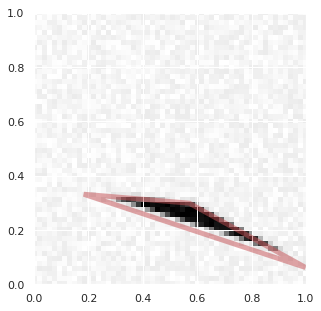

In [36]:
# vizualize 1 sample from the training set
sns.set(style='white')
ind = 100
mp1.visualize_prediction(X_train_6[ind], Y_train_6[ind]*Y_std_6+Y_mean_6)

In [38]:
# build a model
IMSIZE = int(mp1.IMAGE_SIZE)

model_reg = keras.Sequential()
model_reg.add(keras.layers.Reshape((IMSIZE,IMSIZE,1),input_shape=X_train_6.shape[1:]))
model_reg.add(keras.layers.Conv2D(16,(5,5),activation=keras.activations.relu))
model_reg.add(keras.layers.MaxPooling2D())
model_reg.add(keras.layers.Conv2D(16,(5,5),activation=keras.activations.relu))
model_reg.add(keras.layers.MaxPooling2D())
model_reg.add(keras.layers.Conv2D(16,(5,5),activation=keras.activations.relu))
model_reg.add(keras.layers.MaxPooling2D())
model_reg.add(keras.layers.Dropout(0.2))
model_reg.add(keras.layers.Flatten())
model_reg.add(keras.layers.Dense(6,activation=keras.activations.linear))
model_reg.add(keras.layers.Dropout(0.2))

In [53]:
# train the model
model_reg.compile(optimizer=keras.optimizers.Adam(lr=0.001),
             loss=keras.losses.mae,
             metrics=[keras.metrics.mse,keras.metrics.mae])
model_reg.fit(X_train_6,Y_train_6,epochs=20,verbose=1,validation_data=(X_test_6,Y_test_6))

Train on 3000 samples, validate on 300 samples
Epoch 1/20
3000/3000 [==============================] - 31s 10ms/step - loss: 0.5101 - mean_squared_error: 0.4633 - mean_absolute_error: 0.5101 - val_loss: 0.4430 - val_mean_squared_error: 0.3513 - val_mean_absolute_error: 0.4430
Epoch 2/20
3000/3000 [==============================] - 38s 13ms/step - loss: 0.4892 - mean_squared_error: 0.4377 - mean_absolute_error: 0.4892 - val_loss: 0.4085 - val_mean_squared_error: 0.3093 - val_mean_absolute_error: 0.4085
Epoch 3/20
3000/3000 [==============================] - 29s 10ms/step - loss: 0.4708 - mean_squared_error: 0.4127 - mean_absolute_error: 0.4708 - val_loss: 0.4094 - val_mean_squared_error: 0.3046 - val_mean_absolute_error: 0.4094
Epoch 4/20
3000/3000 [==============================] - 26s 9ms/step - loss: 0.4557 - mean_squared_error: 0.3931 - mean_absolute_error: 0.4557 - val_loss: 0.3887 - val_mean_squared_error: 0.2793 - val_mean_absolute_error: 0.3887
Epoch 5/20
3000/3000 [============

In [56]:
pred = model_reg.predict(X_test_6)

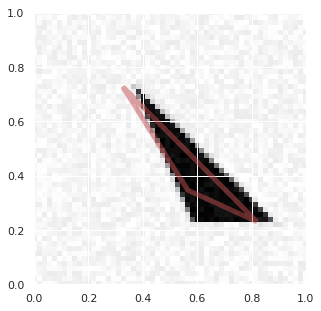

In [68]:
sns.set(style='white')
ind = 120
mp1.visualize_prediction(X_test_6[ind], pred[ind]*Y_std_6+Y_mean_6)

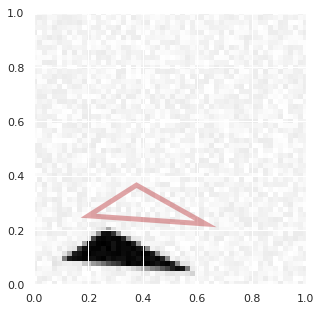

In [63]:
sns.set(style='white')
ind = 115
mp1.visualize_prediction(X_test_6[ind], pred[ind]*Y_std_6+Y_mean_6)

## Q7

Our task here is to denoise the images, which can be done by segmenting the shapes. We implement a hourglass neural net, which performs regression on the known 2 subimages (noise / shape) to produce 2 probability distributions (shown as heatmaps), of which the second one is a predicted segmentation of the shape.

In [4]:
# generate datasets
IMSIZE = int(mp1.IMAGE_SIZE)

n_train = 300
n_test = 300

def generate_denoising_datasets(n_samples,noise):
    images_7,noises_7 = mp1.generate_dataset_denoising(n_samples, noise, free_location=True)
    images_7,noises_7 = images_7.reshape(-1,IMSIZE,IMSIZE),noises_7.reshape(-1,IMSIZE,IMSIZE)
    shapes_7 = images_7-noises_7
    targets_7 = np.stack((shapes_7,noises_7),axis=3)
    return images_7,targets_7
    
train_images_7,train_targets_7 = generate_denoising_datasets(n_train,20)
test_images_7,test_targets_7 = generate_denoising_datasets(n_test,20)

Creating data:



Categories: rectangle/disk/triangle
Creating data:



Categories: rectangle/disk/triangle


In [5]:
### build a model
IMSIZE = int(mp1.IMAGE_SIZE)

inp = keras.Input(shape=train_images_7.shape[1:],dtype="float32")
resh = keras.layers.Reshape((IMSIZE,IMSIZE,1))(inp)

conv1_1 = keras.layers.Conv2D(8,3,activation=keras.activations.relu,padding="same")(resh)
conv1_2 = keras.layers.Conv2D(8,3,activation=keras.activations.relu,padding="same")(conv1_1)
pool1 = keras.layers.MaxPooling2D()(conv1_2)
conv2_1 = keras.layers.Conv2D(16,3,activation=keras.activations.relu,padding="same")(pool1)
conv2_2 = keras.layers.Conv2D(16,3,activation=keras.activations.relu,padding="same")(conv2_1)
pool2 = keras.layers.MaxPooling2D()(conv2_2)
conv3_1 = keras.layers.Conv2D(32,3,activation=keras.activations.relu,padding="same")(pool2)
conv3_2 = keras.layers.Conv2D(32,3,activation=keras.activations.relu,padding="same")(conv3_1)
pool3 = keras.layers.MaxPooling2D()(conv3_2)


up1 = keras.layers.UpSampling2D(size=(2,2))(pool3)
deconv1_1 = keras.layers.Conv2D(32,2,activation=keras.activations.relu,padding="same")(up1)
deconv1_2 = keras.layers.Conv2D(32,3,activation=keras.activations.relu,padding="same")(deconv1_1)
deconv1_3 = keras.layers.Conv2D(32,3,activation=keras.activations.relu,padding="same")(deconv1_2)
up2 = keras.layers.UpSampling2D()(deconv1_3)
deconv2_1 = keras.layers.Conv2D(16,2,activation=keras.activations.relu,padding="same")(up2)
deconv2_2 = keras.layers.Conv2D(16,3,activation=keras.activations.relu,padding="same")(deconv2_1)
deconv2_3 = keras.layers.Conv2D(16,3,activation=keras.activations.relu,padding="same")(deconv2_2)
up3 = keras.layers.UpSampling2D()(deconv2_3)
deconv3_1 = keras.layers.Conv2D(8,2,activation=keras.activations.relu,padding="same")(up3)
deconv3_2 = keras.layers.Conv2D(8,3,activation=keras.activations.relu,padding="same")(deconv3_1)
deconv3_3 = keras.layers.Conv2D(8,3,activation=keras.activations.relu,padding="same")(deconv3_2)

deconv4 = keras.layers.Conv2D(2,1,activation=keras.activations.sigmoid,padding="same")(deconv3_3)

model_hg = keras.Model(input=inp,output=deconv4)
model_hg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 72)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 36, 16)        2320      
__________

/home/lucas/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [6]:
# train the model
model_hg.compile(optimizer=keras.optimizers.Adam(lr=0.001),
                 loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy])
model_hg.fit(train_images_7,train_targets_7,epochs=10,verbose=1,validation_data=(test_images_7,test_targets_7))

Train on 300 samples, validate on 300 samples
Epoch 1/10
300/300 [==============================] - 25s 83ms/step - loss: 0.6196 - categorical_accuracy: 0.8576 - val_loss: 0.6050 - val_categorical_accuracy: 0.9450
Epoch 2/10
300/300 [==============================] - 13s 42ms/step - loss: 0.4913 - categorical_accuracy: 0.9438 - val_loss: 0.3697 - val_categorical_accuracy: 0.9450
Epoch 3/10
300/300 [==============================] - 12s 41ms/step - loss: 0.3610 - categorical_accuracy: 0.9438 - val_loss: 0.3560 - val_categorical_accuracy: 0.9450
Epoch 4/10
300/300 [==============================] - 13s 43ms/step - loss: 0.3439 - categorical_accuracy: 0.9438 - val_loss: 0.3345 - val_categorical_accuracy: 0.9450
Epoch 5/10
300/300 [==============================] - 14s 48ms/step - loss: 0.3303 - categorical_accuracy: 0.9438 - val_loss: 0.3248 - val_categorical_accuracy: 0.9450
Epoch 6/10
300/300 [==============================] - 14s 46ms/step - loss: 0.3211 - categorical_accuracy: 0.9438 

In [94]:
pred = model_hg.predict(test_images_7)
noise_threshold = 0.13

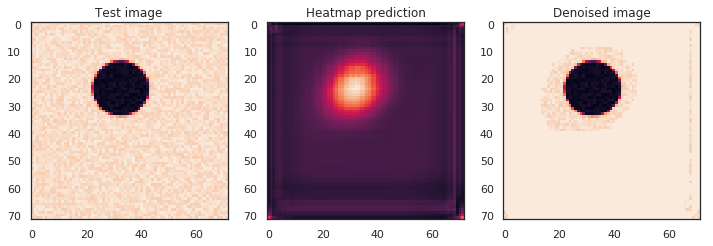

In [101]:
sns.set(style='white')
ind = 5
plt.figure(figsize=(12,15))
plt.subplot(1,3,1)
plt.imshow(test_images_7[ind,:,:])
plt.title("Test image")
plt.subplot(1,3,2)
plt.imshow(pred[ind,:,:,1])
plt.title("Heatmap prediction")
plt.subplot(1,3,3)
plt.imshow((pred[ind,:,:,1]>noise_threshold)*(test_images_7[ind,:,:]-1))
plt.title("Denoised image")
plt.show()

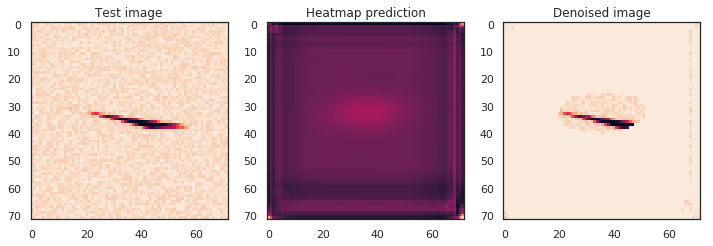

In [102]:
sns.set(style='white')
ind = 0
plt.figure(figsize=(12,15))
plt.subplot(1,3,1)
plt.imshow(test_images_7[ind,:,:])
plt.title("Test image")
plt.subplot(1,3,2)
plt.imshow(pred[ind,:,:,1])
plt.title("Heatmap prediction")
plt.subplot(1,3,3)
plt.imshow((pred[ind,:,:,1]>noise_threshold)*(test_images_7[ind,:,:]-1))
plt.title("Denoised image")
plt.show()

For rendering the denoised images, one solution is to run the model on the test image to get a probability distribution over the location of the shape. We then *manually* set a threshold over this distribution (`noise_threshold=0.13` looks like a good compromise on various images...) and apply this filter to the test image. Note that we apply `image-1` before the filter, so that the background appears white (instead of black) when plotting.